Copyright 2024 Google LLC
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
    https://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Getting Started with EZ-WSI DICOMweb

EZ-WSI DICOMweb is a Python library that provides fast and easy access to digital pathology images. The library supports accessing images from DICOMweb-accessible [DICOM Stores](https://cloud.google.com/healthcare-api/docs/how-tos/dicom), [Google Cloud Storage](https://cloud.google.com/storage?hl=en) (GCS),  and local storage. When accessing images from a DICOM store, the library provides methods to accelerate image retrieval.  All images accessed using the API can be easily converted into ML embeddings using the Google Pathology Embeddings Research API. A DICOM conformance statement for the  EZ-WSI library is available here.

Google Pathology Embeddings is an ML foundation model developed to accelerate the development of digital pathology ML algorithms. This foundation model was trained on pathology images using self-supervised methods. To learn more about Google Pathology Embeddings, see the [blog post](https://research.google/blog/health-specific-embedding-tools-for-dermatology-and-pathology/).


**This Colab walks through a series of examples to demonstrate how to get started using EZ-WSI DICOMweb:**

1.   [Connecting EZ-WSI DICOMweb to DICOM slide imaging](#init_dicomweb)
2.   [Enabling EZ-WSI DICOMweb frame cache](#cache)
3.   [Listing DICOM slide pyramid level images](#listing_pyramid_imaging)
4.   [Retrieving a pyramid level image by index](#index_access)
5.   [Image dimensions (pixel spacing)](#pixel_spacing)
6.   [Finding pyramid level images by pixel spacing](#find_by_pixelspacing)
7.   [Normalizing pyramid level pixel spacing (resizing)](#normalize_pixelspacing)
8.   [Retrieving a patch from a level image and downsampled level image](#get_patch)
9.  [ICC profile color normalization](#color_correction)
10.   [Generating patches from a level image](#generate_patches)

**Complete end-to-end example**
A complete end-to-end example that illustrates initialization and patch generation is shown [here](#complete_example).


In [ ]:
# @title Pip install EZ-WSI DICOMweb
%%capture
!pip install --upgrade ez_wsi_dicomweb>=6.0.6

In [ ]:
# @title Authenticate Colab
# Authenticate user for access. There will be a popup asking you to sign in with your user account and approve access.
from google.colab import auth
auth.authenticate_user()

In [ ]:
# @title Define Colab specific code to display output
# Imports for CoLab Output
from ez_wsi_dicomweb import patch_generator
from google.colab import data_table
from matplotlib import pyplot as plt
import pandas as pd


# Code to render tables and figures in co-lab

def init_subplot(height: int, width: int):
  # Boiler plate code to init matplotlib to render multi-image figure.
  fig, sub_plots = plt.subplots(height, width)
  fig.set_figwidth(10)
  fig.set_figheight(10)
  fig.tight_layout()
  return sub_plots

def show_image (title: str, img, sub_plot = None):
  # Boiler plate code to render image in coloab using matplotlib.
  if sub_plot is not None:
    sub_plot.set_title(title)
    sub_plot.imshow(img)
    return
  plt.title(title)
  plt.imshow(img)
  plt.show()

def show_table(headers, rows):
  # Boiler plate code to tables image in coloab.
  df = pd.DataFrame({header: [row[index] for row in rows] for index, header in enumerate(headers)})
  return data_table.DataTable(df, include_index=False)

def show_generated_patches(max_columns: int,
                           max_rows: int,
                           patch_generator:patch_generator.DicomPatchGenerator,
                           profile_transformation = None):
  # Boiler plate code display patches of images using matplotlib.
  sub_plots = init_subplot(max_rows, max_columns)
  column = 0
  row = 0
  for i, patch in enumerate(patch_gen):
    if i == max_rows * max_columns:
      break
    column = int(i % max_columns)
    row = int(i / max_columns)
    show_image(
               '',
               patch.image_bytes(profile_transformation),
               sub_plots[row, column]
              )
  for i in range(i+1, max_rows * max_columns):
    column = int(i % max_columns)
    row = int(i / max_columns)
    sub_plots[row, column].set_visible(False)
  plt.tight_layout()
  plt.show()


# DICOM Digital Pathology Imaging

[DICOM](https://www.dicomstandard.org/) is the interoperable standard through which medical imaging (Pathology, Radiology, Cardiology, *etc*.) is communicated. The DICOM standard supports  photo-micrographs and [Whole Slide Digital Pathology Imaging](https://pubmed.ncbi.nlm.nih.gov/30533276/). Whole slide digital pathology images are some of the largest medical imaging commonly acquired. The DICOM standard supports high performance random access to this imaging, panning and zooming. EZ-WSI DICOMweb is implemented on top of DICOMweb standard to simplify and accelerate the retrieval of digital pathology imageing.

**DICOM representation of whole slide digital pathology.**

Whole Slide digital pathology Imaging (WSI) are represented in DICOM as an image pyramid. Each level of the pyramid defines a representation of the image at a specific zoom level, pixel spacing. Pyramid levels are themselves represented as a collection of non-overlapping smaller images, frames. In addition to describing the image pyramid the standard also defines additional optional images: a label, overview, and thumbnail image. The label image captures the slides label. The overview describes the slide as a whole and may include annotations which define the region of the slide which was captured in the pyramid imaging, and the thumbnail is a single relatively small image that represents the pyramid imaging as an non-tiled image.  **EZ-WSI DICOMweb provides mechanisms to easily access the image pyramid and if defined the label, thumbnail, and overview imaging**.


![DICOM whole slide image pyramid.](https://dicom.nema.org/dicom/dicomwsi/sup145_fromword_files/image008.gif)

Image: [DICOM Standard Supplement 145](https://dicom.nema.org/dicom/dicomwsi/).

# <a name="init_dicomweb">Connecting EZ-WSI DICOMweb to DICOM Imaging.</a>

EZ-WSI DICOMweb requires that users of the library identify the DICOM store, and the study instance uid and series instance uid of the slide imaging that will be accessed by provideing a full DICOMweb path, url + path, to the slide imaging. If authentication is required to connect to the DICOM store, users are required to provide EZ-WSI with credentials to access the store.

DICOM imaging is identified through the combination of three [UIDs](https://dicom.nema.org/dicom/2013/output/chtml/part05/chapter_9.html); study instance UID, series instance UID, and a SOP instance UID. These UIDs form a relatively hierarchy and an information organizational structure. Using the DICOM Standard information model, a patient maps to one or more study instance UID. The study instance UID can be thought of as a globally unique value that identifies the collection of imaging acquired at a patient's exam. Each series instance UIDs contained within a Study Instance UID conceptually correspond to each unique medical imaging acquisition which occurred as a result of the exam. Each series instance UID in turn contains one or more images that when taken togeather describe the image acquisition, each of these is represented by a unique SOP instance UID.

The Colab retrieves a WSI from a Google DICOM store.  The slide imaging can be accessed using DICOMweb at: https://healthcare.googleapis.com/v1/projects/hai-cd3-foundations/locations/us-west1/datasets/pathology/dicomStores/camelyon/dicomWeb/studies/1.3.6.1.4.1.11129.5.7.999.186491099540.79362771.1709051338085017/series/1.3.6.1.4.1.11129.5.7.999.186491099540.79362771.1709051338893019. The code below connects EZ-WSI DICOMweb to a Google DICOM store.

***Performance TIP***

The DICOM Slide constructor initalizes EZ-WSI state by reading metadata that describes the referenced imaging (series_path) from the DICOM store storing the imaging. It is generally recommended that repeated initialization of the Dicom Slide class be avoided to avoid redundant metadata reads.

In [ ]:
# This section imports python library dependenceis that will be used in the
# coloab

from ez_wsi_dicomweb import credential_factory
from ez_wsi_dicomweb import dicom_slide
from ez_wsi_dicomweb import dicom_web_interface
from ez_wsi_dicomweb import local_dicom_slide_cache_types
from ez_wsi_dicomweb import patch_generator
from ez_wsi_dicomweb import pixel_spacing
from ez_wsi_dicomweb.ml_toolkit import dicom_path

'''Start here.
Populate the following fields with the relevant information.
These should match information from your gcloud DICOM store.
See the gcloud dicom guide for more information:
  https://cloud.google.com/healthcare-api/docs/how-tos/dicom.

Search the file for "Try here" for interactive sections.
'''

project_name = 'hai-cd3-foundations' # remove''
location = 'us-west1' # remove #'' # e.g. us-west1
dataset_id = 'pathology' # remove
dicom_store_id = 'camelyon' # remove
study_uid = '1.3.6.1.4.1.11129.5.7.999.186491099540.79362771.1709051338085017' # remove
series_uid = '1.3.6.1.4.1.11129.5.7.999.186491099540.79362771.1709051338893019' # remove

# Define path to slide imaging in GCP DICOM Store
series_path = dicom_path.FromString(
    'https://healthcare.googleapis.com/v1'
    f'/projects/{project_name}/locations/{location}'
    f'/datasets/{dataset_id}/dicomStores/{dicom_store_id}'
    f'/dicomWeb/studies/{study_uid}'
    f'/series/{series_uid}'
)

print(f'Connecting to DICOM Slide Located at: {series_path}')

***Authentication***

An authentication header, [OAuth bearer token](https://developers.google.com/identity/protocols/oauth2), is required to connect <u>directly</u> to a DICOM store. EZ-WSI uses a credential factory to generate credentials and allows for regeneration of those credentials, if needed. The ability to re-generate credientials enables EZ-WSI to re-generate expired crediental and enables the  DicomSlide class to be passed as a parameter through a Dataflow pipeline. EZ-WSI includes five credential factory implementations in credential_factory.py.

1. <u>DefaultCredentialFactory</u>, initalizes a credentials from [application default credientals](https://cloud.google.com/docs/authentication/application-default-credentials). **(Use this factory, for most use cases, when connecting directly to a Google DICOM store.**

```
DefaultCredentialFactory(scopes: Optional[List[str]] = None):
# scopes default to: ['https://www.googleapis.com/auth/cloud-platform',
#        'https://www.googleapis.com/auth/cloud-healthcare',]
```


2. <u>NoAuthCredentialsFactory</u>: This factory omits credentials from requests.  **Use this factory if the DICOM store does not require an authentication token in DICOMweb requests.**

```
NoAuthCredentialsFactory():
```

3. <u>TokenPassthroughCredentialFactory</u>: This factory initalizes a credentials with the provided OAuth bearer token. The credentials returned by the factory cannot be refreshed. This factory is useful for services which are being built to proxy requests.

```
TokenPassthroughCredentialFactory(bearer_token: str):
```

4. <u>ServiceAccountCredentialFactory</u>: This factory enables authentication to be initalized from service account credential JSON.

```
ServiceAccountCredentialFactory(
    json_param: Optional[
        Union[Mapping[str, Any], str, bytes, os.PathLike[Any]]
    ] = None,
    scopes: Optional[List[str]] = None,
):
# json_param: JSON containing service account info in Google format or a file
#   which should be read which contains JSON formatted service account info
#
# scopes default to: ['https://www.googleapis.com/auth/cloud-platform',
#        'https://www.googleapis.com/auth/cloud-healthcare',]
```

5. <u>GoogleAuthCredentialFactory</u>: This factory enables externally provided [google.auth.credentials.Credentials](https://google-auth.readthedocs.io/en/stable/reference/google.auth.credentials.html) to be used. This credential factory does not support credential regeneration.

```
GoogleAuthCredentialFactory(credentials: google.auth.credentials.Credentials):
```

 The code that follows initalizes the EZ-WSI DICOMweb [application default credientals](https://cloud.google.com/docs/authentication/application-default-credentials) factory. This factory will return the credientals associated with the Colab user account.

In [ ]:
### Creates a factory to use application default credientals to authenticate DICOMweb requests
credientals = credential_factory.DefaultCredentialFactory()

***Connecting to the DICOM Store***

The code that follows retrieval the EZ-WSI DICOMweb DicomSlide class. This is the core class through which slide imaging is referenced and image bytes are initializes. The DicomSlide constructor retrieves DICOMweb metadata to identify the series's slide imaging in the DICOM store; pixel data is not retrieved.

**Performance TIP**

It is recommended that repeated initialization of the Dicom Slide class be avoided to avoid redundant metadata reads. Metadata retrieveal while efficient count against the store's total query per minute transaction quota.

In [ ]:
ds = dicom_slide.DicomSlide(
      dwi=dicom_web_interface.DicomWebInterface(
        credientals
      ),
      path=series_path,
    )

# <a name="cache">Enabling EZ-WSI DICOMweb Frame Cache</a>

At high magnifications, low pixel spacing, it is not uncommon for digital pathology pyramid levels to have 10 - 100's of thousands of frames. To accellerate imaging retrieval, EZ-WSI DICOMweb can be configured to fetch frames in blocks and cache them for subsequent use. The performance gains from doing this can be substantial, ~100x, when compared with repeated requests for individual frames. Once the slide cache is enabled the frame caching operates transparently in the background. The slide cache will pre-fetch blocks of frames or entire instances as needed. The total memory size of the frame cache can be controlled via a built in LRU. Frame cache initialization returns an instance of the cache. The frame cache has methods which can be used to monitor the cache performance.

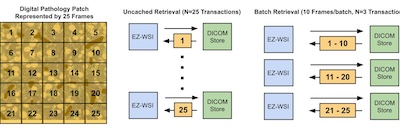

```
def init_slide_frame_cache(
      self,
      max_cache_frame_memory_lru_cache_size_bytes: Optional[int] = None,
      number_of_frames_to_read: int = 500,
      max_instance_number_of_frames_to_prefer_whole_instance_download: int = 10000,
      optimization_hint: local_dicom_slide_cache_types.CacheConfigOptimizationHint = local_dicom_slide_cache_types.CacheConfigOptimizationHint.MINIMIZE_DICOM_STORE_QPM,
  ) -> InMemoryDicomSlideCache:
```

**Performance Tip**
The performance of the cache can be optimized by programatically pre-loading patch <u>once</u> prior to issueing requests for requests for image or patch pixel bytes. If patch imaging is not pre-loaded then cache performance is optmized by accessing patches left-to-right top-to-bottom.



In [ ]:

# Initialize in client side memory cache for the slide.
# Batch Optimization hints= MINIMIZE_DICOM_STORE_QPM or MINIMIZE_LATENCY.
# MINIMIZE_DICOM_STORE_QPM: EZ-WSI blocks and waits for cache to finish loading
# before returning frames. Recommended setting.
# MINIMIZE_LATENCY: Batch load frames async. If a frame is requested for
# frame that is not in cache, then EZ-WSI will issue two requests, a larger one
# to batch loads frames into the cache, and a individual frame request to
# to retrieve and return the requested frame data immediately. This second
# request increases the number of queries against the DICOM store and, may, slow
# data retrieval for the batched frames, but will return the requested frame
# data with the least latency.
frame_cache = ds.init_slide_frame_cache(
  optimization_hint=local_dicom_slide_cache_types.CacheConfigOptimizationHint.MINIMIZE_DICOM_STORE_QPM
)

# Resets frame cache internal monitor. Shown here for demonstration purposes
# only. Cache monitor initalized in reset.
frame_cache.reset_cache_stats()

# Returns a Python dataclass that contains frame cache usage statistics.
frame_cache.cache_stats

**Programmatically optimizing frame caching**

The EZ-WSI DICOM frame cache can be manually initialized by selectively pre-loading frames that will be used into the cache prior to their use. An example of patch preloading in this Colab is shown [here](#preloading).

<u>To preload all of the frames within a level image or downsampled level image</u>
```
ds.preload_level_in_frame_cache(level)

```
<u>To preload a patch or sequence of patches</u>
```
ds.preload_patches_in_frame_cache(patch_sequence)
```

It is worth noting that pre-loading frames is not always optimal or necessary. The performance gains achieved by preloading are often modest when compared with the gains achieved simply by enabling the frame cache.

# <a name="listing_pyramid_imaging">Listing DICOM Slide Pyramid Level Images</a>

The pyramid imaging associated with a DICOM slide can be accessed through multiple mechanisms. The `levels` attribute returns an iterator over all of the image pyramid levels stored on a DicomSlide. Levels are returned in order from highest magnification to lowest magnification.

In [ ]:
### Using DicomSlide discover images stored within the slides series
#
# pyramid levels = images used to represent whole slide images in the pyramid
print ('Pyramid Images in slide')
header = ['level index', 'width x height (px)', 'Minimum horizontal/vertical pixel spacing (mm/px)']
rows = [[l.level_index, f'{l.width} x {l.height}', round(l.pixel_spacing.pixel_spacing_mm,6)] for l in ds.levels]
show_table(header, rows)

If defined, the label imaging, thumbnail, and overview imaging can be accessed by attribute from the DicomSlide. The Colab demo imaging defines an overview imaging only.


In [ ]:
# If present Label, Thumbnail, and Overview images are also represented as slide levels
# Pixel spacing on these levels is likely meaningless.
print('Label, Thumbnail, and Overview images in slide.')
header = ['level index', 'width x height (px)']
rows = []
for title, level in ( ('label', ds.label), ('thumbnail', ds.thumbnail),  ('overview', ds.overview)):
  if level is None:
    rows.append([f'No {title} Image.'] * len(header))
  else:
    rows.append([level.level_index, f'{level.width} x {level.height}'])
show_table(header, rows)


#<a name="index_access">Retrieving Pyramid Level Image by Index</a>

Level index is a pyramid specific key that provides direct access to the slide pyramid levels. If defined, the levels associated with a label, overview, or thumbnail can be accessed by index or attribute. After identifying the desired level, an RGB image representation of the entire level can be retrieved using.

```
image = ds.get_image(level)
uncompressed_image bytes = image.image_bytes()  # returns numpy array
```

The uncompressed bytes associated with the image are retrieved from the DICOM store when the call to `image.image_bytes()` is performed.

Generating images of an entire pyramid level can be a very <u>time and resource intensive</u> task. At high magnifications, digital pathology images are gigapixel images and retrieving these images can cause out of memory conditions. Typically the images of entire levels should be retrieved at a low magnification and these images should be used to identify the areas of interest (patches) retrieved at a high magnification.

In [ ]:
sub_plots = init_subplot(2,2)

# Get Level by "level index; retrieve level 11"
level = ds.get_level_by_index(11)
image = ds.get_image(level)
rgb_values = image.image_bytes()
show_image('Level 11', rgb_values, sub_plots[0,0])

# Get Level by "level index; 9"
# Image looks simlar to level 11, however axis on edges
# indicates that the image has greater pixel area.
level = ds.get_level_by_index(9)
rgb_values = ds.get_image(level).image_bytes()
show_image('Level 9', rgb_values,  sub_plots[0,1])

# Requesting overview image by attribute.
level = ds.overview
rgb_values = ds.get_image(level).image_bytes()
show_image('Overview Image by attribute', rgb_values, sub_plots[1,0])

# Get overview image by index.
level = ds.get_level_by_index('OVERVIEW')
rgb_values = ds.get_image(level).image_bytes()
show_image('Overview Image by index', rgb_values,  sub_plots[1,1])

# <a name="pixel_spacing">Image Dimensions (Pixel Spacing)</a>

The physical dimensions of a pixel in digital pathology images are encoded by slide scanners and expressed in DICOM as [pixel spacing](https://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_10.7.html#sect_10.7.1.3). Pixel spacing is the real world distance in mm between two adjacent pixel centers. EZ-WSI slide pyramid levels have a pixel spacing attribute.




In [ ]:
level = ds.native_level  # Get level corresponding to highest magnfication
print(f'Width: {level.width} px  Width spacing: {level.pixel_spacing.column_spacing_mm} mm/px    Width physical dimension: {level.pixel_spacing.column_spacing_mm * level.width} mm')
print(f'Height: {level.height} px  Height spacing: {level.pixel_spacing.row_spacing_mm} mm/px    Height physical dimension: {level.pixel_spacing.row_spacing_mm * level.height} mm')
print(f'Minimum horizontal/vertical pixel spacing: {level.pixel_spacing.pixel_spacing_mm} mm/px')


**Pixel spacing and magnification**

Pixel spacing and magnification are not completely interchangeable concepts. Pixel spacing is affected by the optical path of the slide scanning during image acquisition only. In contrast, the [magnification](https://pubmed.ncbi.nlm.nih.gov/24083056/) of a digital pathology image on a monitor is <u>also</u> affected by the DPI of the monitor and the distance of the viewer to the monitor. EZ-WSI provides methods to estimate  magnification of a pixel spacing and to initialize pixel spacing from a magnification string. EZ-WSI converts between magnification and pixel spacing using the following arithmetic.

```Magnification = Scale Factor / Pixel Spacing```.

Scale factor defaults to 0.01. EZ-WSI represents physical dimensions in standard DICOM units (mm/px) and uses a PixelSpacing class to represent spacing. Pixel spacing objects can also be initialized directly.



In [ ]:
# The following examples create representation of pixels spacing from magnifications
# these are generated using the approximation described above.

low_ps = pixel_spacing.PixelSpacing.FromMagnificationString('0.625X')
print(f'Magnification: {low_ps.as_magnification_string}   Pixel Spacing: {low_ps.pixel_spacing_mm} mm/px')
medium_ps = pixel_spacing.PixelSpacing.FromMagnificationString('10X')
print(f'Magnification: {medium_ps.as_magnification_string}   Pixel Spacing: {medium_ps.pixel_spacing_mm} mm/px')
high_ps = pixel_spacing.PixelSpacing.FromMagnificationString('40X')
print(f'Magnification: {high_ps.as_magnification_string}   Pixel Spacing: {high_ps.pixel_spacing_mm} mm/px')

# This example defines pixel spacing directly. Here pixel spacing of both the
# horizontal and vertical dimensions can be defined; the units are always mm/px
column_px_spacing = 0.016
row_px_spacing = 0.016
user_defined_pixel_spacing = pixel_spacing.PixelSpacing(column_px_spacing, row_px_spacing)
print ('\nUser intialized pixel spacing.')
print(f'Magnification: {user_defined_pixel_spacing.as_magnification_string}   Pixel Spacing: {user_defined_pixel_spacing.pixel_spacing_mm} mm/px')

#<a name="find_by_pixelspacing">Finding Pyramid Level Images By Pixel Spacing</a>

For many applications it is desirable to retrieve pyramid image which is as close as possible to a desired  pixel spacing. To accomplish this the DicomSlide class has a ```get_level_by_pixel_spacing``` method. The method  returns the level with a pixel spacing closest to the search target. The method returns None if a level cannot be found.

```
def get_level_by_pixel_spacing(
      self,
      pixel_spacing_mm: float,
      relative_pixel_spacing_equality_threshold: float = 0.25,
      maximum_downsample: float = 0.0
) -> Optional[Level]:
```

The method has two optional parameters.
1. *relative_pixel_spacing_equality_threshold*: Defines the relative difference at which search pixel spacing and slide level pixel spacing are considered equivalent. By default pixel spacing that is within 25% is considered as having the same pixel spacing.

2. *maximum_downsample*: If a pyramid level with "equal" pixel spacing cannot be found then this parameter defines the maximum scaling factor (e.g., 8X) that it is acceptable to return higher magnification imaging. By default this parameter is disabled.

In the example below the slide is searched for a pixel spacing which falls between level 7 and 8. The method returns level 7.

In [ ]:
# Retrieves image within a slide pyramid by pixel spacing
print(f'Search Pixel Spacing: {user_defined_pixel_spacing.pixel_spacing_mm} mm/px')
level = ds.get_level_by_pixel_spacing(user_defined_pixel_spacing)

# Display image in Colab.
image = ds.get_image(level)
rgb_values = image.image_bytes()
show_image(f'Retrieved level index: {level.level_index}; Pixel spacing: {level.pixel_spacing.pixel_spacing_mm}', rgb_values)

**Example of retrieving level outside of equality threshold range**




In [ ]:
# define pixel spacing outside of default equality threshold spacing.
ps = pixel_spacing.PixelSpacing(0.35, 0.35)

# set maximum downsample to 8.0x
level = ds.get_level_by_pixel_spacing(ps, maximum_downsample=8.0)
print(f'level.level_index: {level.level_index};  width: {level.width} x height: {level.height}')
image = ds.get_image(level)
show_image('level', image.image_bytes())

# <a name="normalize_pixelspacing">Normalizing Pyramid Level Pixel Spacing (Resizing)</a>

For many applications it is beneficial to normalize the pixel spacing of imaging to ensure that across a set of slides all slide imaging is represented at a common pixel spacing. To accomplish this, the slide class level provides the `scale_factors` and `resize` methods. The `scale_factors` method returns the horizontal and vertical scale factors necessary to convert the source pixel spacing to the desired target, downsample imaging increases spacing. The `resize` method returns a downsampled representation of the slide level. The data retrieval costs of generating the downsampled imaging are a function of the size of the source imaging required to generate the downsampled image.

In [ ]:
# Determine scaling factors required to scale source imaging to target ps, use
# method to determine if scaling is necessary.
horizontal_scale_factor, vertical_scale_factor = level.scale_factors(ps)
print(f'Horizontal and vertical scaling factors to resize imaging to target ps: {horizontal_scale_factor} x {vertical_scale_factor}')

# Downsample level to target pixel spacing.
downsample_level = level.resize(ps)
print(f'width: {downsample_level.width} x height: {downsample_level.height}, spacing: {downsample_level.pixel_spacing.pixel_spacing_mm} mm/px')

# Retrieve and show image.
# Lower pixel spacing image shown. Cost of image retrieval is based on size
# of source imaging.
image = ds.get_image(downsample_level)
show_image('downsampled level', image.image_bytes())


Alternatively, level scale factors and downsampling can be defined relative to target image dimensions.



In [ ]:
# Determine scaling factors required to scale source imaging to target
# dimensions, use method to determine if scaling is necessary.
horizontal_scale_factor, vertical_scale_factor = level.scale_factors(dicom_slide.ImageDimensions(67, 153))
print(f'Horizontal and vertical scaling factors to resize imaging to target ps: {horizontal_scale_factor} x {vertical_scale_factor}')

# Downsample level to target dimensions.
downsample_level = level.resize(dicom_slide.ImageDimensions(67, 153))
print(f'width: {downsample_level.width} x height: {downsample_level.height}, spacing: {downsample_level.pixel_spacing.pixel_spacing_mm} mm/px')

# Retrieve and show image.
# Lower pixel spacing image shown. Cost of image retrieval is based on size
# of source imaging.
image = ds.get_image(downsample_level)
show_image('downsampled level', image.image_bytes())

# <a name="get_patch">Retrieving a Patch From a Level Image and Downsampled Level Image</a>

Patches, rectangular sub-regions of slide level, are retrieved from the DicomSlide using the get_patch method. Pixel data for the patches are retrieved when the Patch's `get_bytes` method is called. When pre-emptive frame [caching](#cache) is not enabled, which is not recommended, get bytes will retrieve only the frames required to render the patch. With frame caching enabled, if the frames required to render the patch are not found in the cache, then the patch will retrieve the missing frame and additional frames as defined by the pre-emptive cache settings.

**Performance Tip**

As described previously, EZ-WSI DICOMweb can be optionally configured to use an in memory cache to accelerate patch retrieval. The default caching functions are optimized to best accelerate patch retrieval when patches are retrieved in order left-right top-to-bottom.

In [ ]:
###  Extract a patch of a tissue sample.
sub_plots = init_subplot(1,2)

level = ds.get_level_by_pixel_spacing(pixel_spacing.PixelSpacing(0.016, 0.016))
level_mag = level.pixel_spacing.as_magnification_string

# Retrieve whole downsampled image, to display a reference.
show_image(f'Whole Level at Magnification {level_mag}', ds.get_image(level).image_bytes(), sub_plots[0])

# Get retrieve patch from image.
x_origin = 350
y_origin = 1850
width = 300
height = 400
tissue_patch = ds.get_patch(
    level, x=x_origin, y=y_origin, width=width, height=height
).image_bytes()

show_image(f'Patch at Magnification {level_mag}', tissue_patch, sub_plots[1])

**Retrieve patch from downsampled level**

Patches can be sampled from downsampled levels. The code below downsamples the previously shown image to an image 67 px x 153 px (columns, rows) and then retrieves the region previously retrieved.

In [ ]:
sub_plots = init_subplot(1,2)

# Downsample previous level.
downsample_level = level.resize(dicom_slide.ImageDimensions(67, 153))

# get downsampling scale factor use scaling fractor to adjust previously used
# patch coordinates.
horizontal_scale_factor, vertical_scale_factor =level.scale_factors(dicom_slide.ImageDimensions(67, 153))

print(f'Source Image width: {level.width} x height: {level.height}, spacing: {level.pixel_spacing.pixel_spacing_mm} mm/px')
print(f'Downsampling scale factor: {horizontal_scale_factor} x {vertical_scale_factor}')
print(f'Downsampled Image width: {downsample_level.width} x height: {downsample_level.height}, spacing: {downsample_level.pixel_spacing.pixel_spacing_mm} mm/px')

# Retrieve whole downsampled image, to display a reference.
show_image('Downsampled level', ds.get_image(downsample_level).image_bytes(), sub_plots[0])

# Get retrieve patch from downsampled image.
x_origin = int(x_origin / horizontal_scale_factor)
y_origin = int(y_origin / vertical_scale_factor)
width = int(width / horizontal_scale_factor)
height = int(height / vertical_scale_factor)
tissue_patch = ds.get_patch(
    downsample_level, x=x_origin, y=y_origin, width=width, height=height
).image_bytes()

# Display image
level_mag = downsample_level.pixel_spacing.as_magnification_string
show_image(f'Patch at Magnification {level_mag}', tissue_patch, sub_plots[1])

# <a name="color_correction">ICC Profile Color Normalization</a>
The color space digital pathology imaging captured varies by slide scanner vendor. As a result, if the same imaging is acquired by two different vendors' systems the raw uncalibrated images may appear quite different when viewed side-by-side on a monitor. When digital pathology is acquired the imaging is typically encoded with the [ICC Color Profile](https://en.wikipedia.org/wiki/ICC_profile) of the slide scanner that acquired the image. This color profile describes how to transform the RGB color values encoded within the image into a universal color space and can be used to normalize the imaging into a common color space. EZ-WSI supports ICC Profile color normalization for all imaging. The get_bytes methods on dicom_slide.Image, dicom_slide.DicomPatch and gcs_image.GcsImage, gcs_image.GcsPatch all accept an optional parameter to define an ICC Profile for the returned imaging. If an ICC Profile is  provided and the DICOM image is encoded with an ICC Color profile then the returned uncompressed bytes will be transformed from the color space in the DICOM imaging to the target color space. EZ-WSI DICOMweb includes ICC Color profiles for three reference color spaces, SRGB, ROMMRGB, and ADOBERGB these can be used as reference color spaces for normalization.

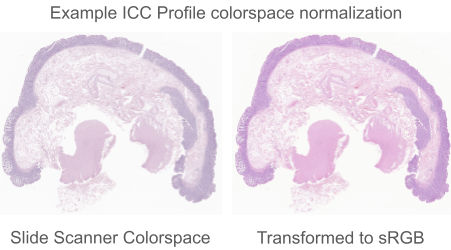

Functions in dicom_slide module which return reference icc profiles.

```
def get_adobergb_icc_profile() -> ImageCms.core.CmsProfile:
def get_rommrgb_icc_profile() -> ImageCms.core.CmsProfile:
def get_srgb_icc_profile() -> ImageCms.core.CmsProfile:
```

DicomSlide method that generates a color transformation from the slide color space to target color space. Returns None if slide does not define icc color profile.
```
  def create_icc_profile_transformation(
      self,
      icc_profile: Union[bytes, ImageCms.core.CmsProfile],
      rendering_intent: ImageCms.Intent = ImageCms.Intent.PERCEPTUAL,
  ) -> Optional[ImageCms.ImageCmsTransform]:
```




In [ ]:
# icc profile to transform imaging to.
profile_bytes = dicom_slide.get_adobergb_icc_profile()

# create a transformation to transform from the slide's colorspace to the desired target colorspace.
profile_transformation = ds.create_icc_profile_transformation(profile_bytes)

# returns tissue patch transformed to target colorspace.
tissue_patch = ds.get_patch(level, x=350, y=1850, width=300, height=400).image_bytes(profile_transformation)

# <a name="generate_patches">Generating Patches from Level Imaging</a>
EZ-WSI DICOMweb contains a utility to automate the selective generation of  patches from level imaging and downsampled level imaging.The DicomPatchGenerator returns a sequence of patches systematically sampled across an image. The patches produced are square, patch_size px on side, and sampled along the x and y image axis at stride_size px spacing from an area defined by a tissue mask.

The tissue mask can be defined directly (numpy array) or generated by a thresholding algorithm. If defined by thresholding, a relatively low magnification level image from the slides pyramid is generated and thresholded. If undefined the level imaging with magnification ~1.25X will be used. The thresholding algorithm converts the tissue mask to grayscale and defines tissue as being regions of the image with luminance values that fall between 255.0 *  min_luminance and 255.0 * max_luminance. This relatively naive approach works reasonably well for brightfield imaging.
```

Module patch_generator.py

class DicomPatchGenerator(Sequence[dicom_slide.DicomPatch]):
  """A generator for patch sampling in a slide at specified pixel spacing.
  """

  def __init__(
      self,
      dicom_source: Union[
          dicom_slide.DicomSlide, dicom_slide.DicomMicroscopeImage
      ],
      source_image: Union[
          slide_level_map.Level,
          slide_level_map.ResizedLevel,
          pixel_spacing.PixelSpacing,
      ],
      patch_size: int,
      mask: Optional[np.ndarray] = None,
      stride_size: Optional[int] = None,
      min_luminance: Optional[float] = None,
      max_luminance: Optional[float] = None,
      mask_level: Union[
          slide_level_map.Level,
          slide_level_map.ResizedLevel,
          pixel_spacing.PixelSpacing,
          None,
      ] = None,
      mask_color_transform: Union[ImageCms.ImageCmsTransform, None] = None,
  ):
```



In [ ]:
### Create a Patch Generator
level = ds.get_level_by_pixel_spacing(pixel_spacing.PixelSpacing(0.016, 0.016))
patch_gen = patch_generator.DicomPatchGenerator(
    ds,
    # Pyramid level patches will be returned from
    level,
    # patch dimensions in pixel; returns square patches.
    patch_size=100,
    # Spacing (pixels) between patchs.
    stride_size=10,
    max_luminance=0.65
)
print(f'Generator will return {len(patch_gen)} patches.')

**<a name="optimizing_patch_retieval">Optimizing patch image retrieval</a>**

If the image bytes associated with the generated patches are going to be retrieved then frame caching (if enabled) can be optimized by selectively <a name="preloading">preloading</a> the generated patch frames into the frame cache.

**Performance Tip:**
Preloading frames will not improve performance if any of the following are true:
1.  The image_bytes() method will not be called on the returned patches.
2.  The total size in bytes of the returned patches exceeds the frame caches max memory setting or the available memory of machine.

In [ ]:
# preload the patches into the cache.
ds.preload_patches_in_frame_cache(patch_gen)

# now use the list of patches for something else, e.g., here we visualize the
# patch imaging.
show_generated_patches(10,10, patch_gen)

**The DICOMPatchGenerator can generate patches from a DownsampledLevels.**

In [ ]:
### Create a Patch Generator
level = ds.get_level_by_pixel_spacing(pixel_spacing.PixelSpacing(0.016, 0.016))
downsample_level = level.resize(dicom_slide.ImageDimensions(67, 153))
patch_gen = patch_generator.DicomPatchGenerator(
    ds,
    # Pyramid level patches will be returned from
    downsample_level,
    # Spacing (pixels) between patchs.
    stride_size=2,
    # patch dimensions in pixel; returns square patches.
    patch_size=10,
    max_luminance=0.80
)
# preload the list of patches into the cache.
ds.preload_patches_in_frame_cache(patch_gen)

# now use the list of patches for something else, e.g., here we visualize the
# patch imaging.
show_generated_patches(10,10, patch_gen)

# <a name="complete_example">Complete example of using EZ-WSI to generate a list of patches and render the patches</a>

In [ ]:
from ez_wsi_dicomweb import credential_factory
from ez_wsi_dicomweb import dicom_slide
from ez_wsi_dicomweb import dicom_web_interface
from ez_wsi_dicomweb import local_dicom_slide_cache_types
from ez_wsi_dicomweb import patch_generator
from ez_wsi_dicomweb import pixel_spacing
from ez_wsi_dicomweb.ml_toolkit import dicom_path

project_name = 'hai-cd3-foundations' # remove''
location = 'us-west1' # remove #'' # e.g. us-west1
dataset_id = 'pathology' # remove
dicom_store_id = 'camelyon' # remove
study_uid = '1.3.6.1.4.1.11129.5.7.999.186491099540.79362771.1709051338085017' # remove
series_uid = '1.3.6.1.4.1.11129.5.7.999.186491099540.79362771.1709051338893019' # remove

# Define path to slide imaging in GCP DICOM Store
ds = dicom_slide.DicomSlide(
      dwi=dicom_web_interface.DicomWebInterface(
        credential_factory.DefaultCredentialFactory()
      ),
      path=dicom_path.FromString(
    'https://healthcare.googleapis.com/v1'
    f'/projects/{project_name}/locations/{location}'
    f'/datasets/{dataset_id}/dicomStores/{dicom_store_id}'
    f'/dicomWeb/studies/{study_uid}'
    f'/series/{series_uid}'),
)
# Initalize frame cache
fc = ds.init_slide_frame_cache(
  optimization_hint=local_dicom_slide_cache_types.CacheConfigOptimizationHint.MINIMIZE_DICOM_STORE_QPM
)

# Find level with desired pixel spacing.
level = ds.get_level_by_pixel_spacing(pixel_spacing.PixelSpacing(0.016, 0.016))

# icc profile to transform imaging to.
profile_bytes = dicom_slide.get_adobergb_icc_profile()
profile_transformation = ds.create_icc_profile_transformation(profile_bytes)

# Init Patch generator
patch_gen = patch_generator.DicomPatchGenerator(
    ds,
    # Pyramid level patches will be returned from
    level,
    # patch dimensions in pixel; returns square patches.
    patch_size=100,
    # Spacing (pixels) between patchs.
    stride_size=10,
    max_luminance=0.65,
    mask_color_transform=profile_transformation,
)

# preload the list of patches into the cache.
ds.preload_patches_in_frame_cache(patch_gen)

# Show patches in Colab.
show_generated_patches(10,10, patch_gen, profile_transformation=profile_transformation)

# Display time required to retrieve imaging required to generate patches.
print(frame_cache.cache_stats)